### <mark>  Previsione di opportunità di Cross Sell di assicurazioni </mark>

In [1]:
# importo le librerie necessarie

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import Utils as utls
from scipy.stats import pointbiserialr
from sklearn.metrics import matthews_corrcoef
from statistics import mean
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC # Importa SMOTENC
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN 



### Importo il Dataset


In [2]:
df = pd.read_csv("insurance_cross_sell.csv", index_col=0)
print(df.shape)
df.head()

(381109, 11)


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## Data preprocessing


* ####  Verifico eventuali valori mancanti

In [3]:
df.count() - df.shape[0]

# oppure:
# df.isna().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

* #### Verifico la proporzione delle classi della variabile di risposta

In [4]:
classe_1_total_obs = df["Response"][df["Response"]==1].count()

classe_0_total_obs = df["Response"][df["Response"]==0].count()

classe_1_percent = classe_1_total_obs / (classe_1_total_obs + classe_0_total_obs)

classe_0_percent = classe_0_total_obs / (classe_1_total_obs + classe_0_total_obs)

classe_1_percent, classe_0_percent

(0.12256336113815208, 0.877436638861848)

In [5]:
# verifico la proporzioni delle classi della variabile di risposta metodo piu veloce

number_of_classes = df["Response"].value_counts()

classe_0_percent = number_of_classes[0] / (number_of_classes[0] +number_of_classes[1] )

classe_1_percent = number_of_classes[1] / (number_of_classes[0] +number_of_classes[1] )

classe_1_percent, classe_0_percent

(0.12256336113815208, 0.877436638861848)

Le classi risultano essere molto sproporzionate, con proporzione di circa 1:8.

Di conseguenza bisognerà adottare una delle tecniche di ribilanciamento, in particolare quella scelta inizialmente consiste nel penalizzare maggiormente le classificazioni errate della classe minoritaria.

* #### Features Encoding

Le Features Region_Code e Policy_Sales_Channel sono variabili categoriche di conseguenza necessitano di essere codificate.
Tipicamente quando il numero delle classi è basso si può usare la tecnica dell' One-Hot-Encoding, ma in questo caso porterebbe ad un aumento della dimensionalità eccessivo.

Di conseguenza prima si verifica se queste due Features mostrano una qualche correlazione con la variabile target, nel caso la correlazione sia prossima allo zero si potrà tenere in considerazione di eliminarle.

La correlazione verrà verificata con il metodo di Cramer che si basa sul test chi-quadrato di indipendenza, test statistico utilizzato per determinare se esiste una significativa associazione tra due variabili categoriche. A differenza del test chi-quadrato, che fornisce un valore di significatività statistica ma non misura la forza dell'associazione, il Coefficiente di Cramer fornisce una misura della forza di tale associazione.


In [6]:
coeff_cramer_Region_Code = utls.cramers_v(df["Response"], df["Region_Code"])

coeff_cramer_Policy_Sales_Channel = utls.cramers_v(df["Response"], df["Policy_Sales_Channel"])

coeff_cramer_Region_Code, coeff_cramer_Policy_Sales_Channel

(0.13760033300895602, 0.26266143103629336)

Il test ha mostrato scarsa (ma non prossima allo zero) correlazione tra queste due variabili con la variabile target Response.
Per il momento quindi verranno prese in considerazione.

In [7]:
# variabile Gender 

dict_mapping_Gender = {"Male" : 1, "Female" : 0}
df["Gender"] = df["Gender"].map(dict_mapping_Gender) 


# variabile Vehicle_Age	

le = LabelEncoder()
df["Vehicle_Age"] = le.fit_transform(df["Vehicle_Age"])


# variabile Vehicle_Damage	

dict_mapping_Vehicle_Damage = {"Yes" : 1, "No" : 0}
f_map = np.vectorize(lambda t: dict_mapping_Vehicle_Damage[t])
df["Vehicle_Damage"] = f_map(df["Vehicle_Damage"])


Le features critiche sono Region_Code e Policy_Sales_Channel in quanto contengono troppe classi.

Un metodo "giusto" per la loro codifica non esiste in quanto semplicamente bisogna provare e vedere.

Per la features Region_Code si è pensato che avesse senso raggruppare valori vicini in quanto potrebbero rappresentare regione vicine,esempio 1 e 2 potrebbero rappresentare regioni affiancate.

In particolare vengono create 3 classi che potrebbero rappresentare le regioni appartenenti all' area geografica nord, centro e sud di uno stato.

Per la features Policy_Sales_Channel invece non è stato trovato un particolare pattern di raggruppamento di conseguenza si lasceranno inalterate le 3 classi a frequenza più alta e si raggrupperanno le altre.

* ##### Fase 1: raggruppamento delle classi

In [8]:
# variabile Region_Code

bins = [0, 17, 34, float('inf')]
labels = [1, 2, 3]
df["Region_Code"] = pd.cut(df['Region_Code'], bins=bins, labels=labels, right=True)

df["Region_Code"].value_counts()

Region_Code
2    170222
1    107364
3    101502
Name: count, dtype: int64

In [9]:
# variabile Policy_Sales_Channel

value_counts = df['Policy_Sales_Channel'].value_counts()
top_channels = value_counts.head(3).index.tolist()
remaining_channels = value_counts.iloc[3:]

target_sum = 100000
current_sum = 0
group = 1
channel_to_group_map = {}

for channel, count in remaining_channels.items():
    if current_sum + count > target_sum:
        group += 1
        current_sum = count
    else:
        current_sum += count
    channel_to_group_map[channel] = group

df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].apply(
    lambda x: x if x in top_channels else channel_to_group_map[x])

df['Policy_Sales_Channel'].value_counts()


Policy_Sales_Channel
152.0    134784
1.0       92630
26.0      79700
124.0     73995
Name: count, dtype: int64

* ##### One-Hot-Encoding

In [10]:
# variabile Region_Code

df = pd.get_dummies(df, columns=["Region_Code"], prefix_sep='_').astype(int)


# variabile Policy_Sales_Channel

df = pd.get_dummies(df, columns=["Policy_Sales_Channel"], prefix_sep='_').astype(int)

# riposiziono la colonna Responde alla fine
response_column = df.pop("Response")
df["Response"] = response_column

df

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Vintage,Region_Code_1,Region_Code_2,Region_Code_3,Policy_Sales_Channel_1,Policy_Sales_Channel_26,Policy_Sales_Channel_124,Policy_Sales_Channel_152,Response
id,,,,,,,,,,,,,,,,
1,1,44,1,0,2,1,40454,217,0,1,0,0,1,0,0,1
2,1,76,1,0,0,0,33536,183,1,0,0,0,1,0,0,0
3,1,47,1,0,2,1,38294,27,0,1,0,0,1,0,0,1
4,1,21,1,1,1,0,28619,203,1,0,0,0,0,0,1,0
5,0,29,1,1,1,0,27496,39,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381105,1,74,1,1,0,0,30170,88,0,1,0,0,1,0,0,0
381106,1,30,1,1,1,0,40016,131,0,0,1,0,0,0,1,0
381107,1,21,1,1,1,0,35118,161,0,1,0,1,0,0,0,0


* #### visualizzo la heat map per un primo screen della correlazione delle variabili

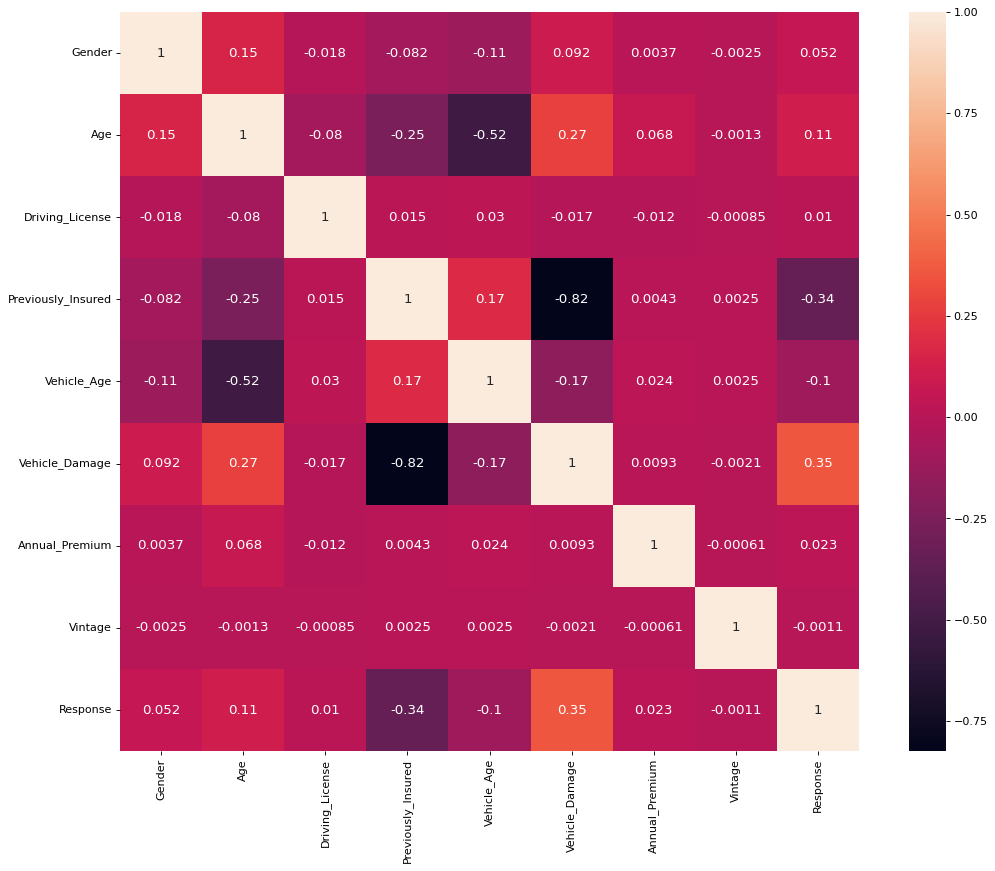

In [11]:
plt.figure(figsize=(16, 12), dpi=80)

df_heat = df.drop(columns=["Region_Code_1",	"Region_Code_2", "Region_Code_3", "Policy_Sales_Channel_1", "Policy_Sales_Channel_26", "Policy_Sales_Channel_124", "Policy_Sales_Channel_152"])

hm = sns.heatmap(df_heat.corr(),
                 cbar=True,
                 square=True,
                 yticklabels=df_heat.columns,
                 xticklabels=df_heat.columns,
                 annot=True,                  #Questo mostra i valori degli indici
                 annot_kws={'size':12})       #Impostare dimensione dell'annotazione a 12 

plt.show()


La HeatMap è molto utile per valutare la correlazione tra diverse variabili. Essendo che fa uso del coefficiente di Correlazione Lineare, le correlazioni che ha senso verificare sono quelle tra variabili continue/discrete.

In questo caso caso quindi questa mappa può essere usata per verificare la correlazione solo tra alcune Features, essendo la variabile di risposta dicotomica.

Di conseguenza si userà:

1. il metodo di Cramer: quando la variabile di risposta è confrontata con una variabile categorica.

2. il metodo Punto-Biseriale: quando la variabile di risposta è confrontata con una variabile continua o discreta.


In [12]:
coeff_cramer_Gender = utls.cramers_v(df["Response"], df["Gender"])
coeff_cramer_Driving_License = utls.cramers_v(df["Response"], df["Driving_License"])
coeff_cramer_Previously_Insured = utls.cramers_v(df["Response"], df["Previously_Insured"])
coeff_cramer_Vehicle_Damage = utls.cramers_v(df["Response"], df["Vehicle_Damage"])


print(f"Correlazione tra Response e Gender: {coeff_cramer_Gender}")
print(f"Correlazione tra Response e Driving_License: {coeff_cramer_Driving_License}")
print(f"Correlazione tra Response e Previously_Insured: {coeff_cramer_Previously_Insured}")
print(f"Correlazione tra Response e Vehicle_Damage: {coeff_cramer_Vehicle_Damage}")

Correlazione tra Response e Gender: 0.052406926239087534
Correlazione tra Response e Driving_License: 0.009937263796981182
Correlazione tra Response e Previously_Insured: 0.3411590351788044
Correlazione tra Response e Vehicle_Damage: 0.3543883050689625


In [13]:
corr_biseriale_Age, p_value_age = pointbiserialr(df["Response"], df["Age"])
corr_biseriale_Vehicle_Age, p_value_Vehicle_Age = pointbiserialr(df["Response"], df["Vehicle_Age"])
corr_biseriale_Annual_Premium, p_value_Annual_Premium = pointbiserialr(df["Response"], df["Annual_Premium"])
corr_biseriale_Vintage, p_value_Vintage = pointbiserialr(df["Response"], df["Vintage"])


print(f"Correlazione tra Response e Age: {corr_biseriale_Age}")
print(f"Correlazione tra Response e Vehicle_Age: {corr_biseriale_Vehicle_Age}")
print(f"Correlazione tra Response e Annual_Premium: {corr_biseriale_Annual_Premium}")
print(f"Correlazione tra Response e Vintage: {corr_biseriale_Vintage}")




Correlazione tra Response e Age: 0.11114689471247871
Correlazione tra Response e Vehicle_Age: -0.10407847053342247
Correlazione tra Response e Annual_Premium: 0.022574695542553022
Correlazione tra Response e Vintage: -0.0010503720019896328


Dall'analisi si ricava che le variabili alla quale la variabile di risposta è maggiormente correlata sono:
1. Vehicle_Damage
2. Previously_Insured


## Creazione di un modello di regressione logistica con tutti i parametri

In [14]:
# divido il dataset in due parti, il primo usato per la validazione, ovvero per la scelta dei parametri da mettere nel modello, il secondo per la fase di test

df_validazione = df[0:int(len(df)*0.5)].copy()
df_test = df[int(len(df)*0.5) +1: len(df)].copy()


In [15]:
RANDOM_SEED = 0

X = df_validazione.drop("Response", axis=1).values
y= df_validazione["Response"].values

kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

train_score_accuracy_score = []
train_score_recall_score = []
train_score_precision_score = []

test_score_accuracy_score = []
test_score_recall_score = []
test_score_precision_score = []

feature_names = df_validazione.drop(columns="Response", axis=1).columns
coeff_regression = pd.DataFrame(columns=feature_names)


for train_index, test_index in kf.split(X):
  
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  ss = MinMaxScaler()
  X_train = ss.fit_transform(X_train)
  X_test = ss.transform(X_test)

  lr = LogisticRegression(class_weight={0: 1, 1: 8})
  lr.fit(X_train, y_train)

  coeff_regression = pd.concat([coeff_regression, utls.get_coeff_logistic_regression(lr, df_validazione)], axis=0, ignore_index=True)

  y_train_predict = lr.predict(X_train)
  y_test_predict = lr.predict(X_test)

  train_score_accuracy_score.append(utls.classification_report(y_train, y_train_predict)[0])
  train_score_precision_score.append(utls.classification_report(y_train, y_train_predict)[1])
  train_score_recall_score.append(utls.classification_report(y_train, y_train_predict)[2])

  test_score_accuracy_score.append(utls.classification_report(y_test, y_test_predict)[0])
  test_score_precision_score.append(utls.classification_report(y_test, y_test_predict)[1])
  test_score_recall_score.append(utls.classification_report(y_test, y_test_predict)[2])


print(f"Accuratezza media fase training: {mean(train_score_accuracy_score)}")
print(f"Precisione media fase training: {mean(train_score_precision_score)}")
print(f"Recall medio fase training: {mean(train_score_recall_score)}")

print(f"Accuratezza media fase test: {mean(test_score_accuracy_score)}")
print(f"Precisione media fase test: {mean(test_score_precision_score)}")
print(f"Recall medio fase test: {mean(test_score_recall_score)}")

print(f"Media del valore assoluto dei coefficienti di regressione: \n {coeff_regression.mean().sort_values(ascending=False)}")



C:\Users\r.allegri\AppData\Local\Temp\ipykernel_26044\3905554027.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  coeff_regression = pd.concat([coeff_regression, utls.get_coeff_logistic_regression(lr, df_validazione)], axis=0, ignore_index=True)


Accuratezza media fase training: 0.6423358554688257
Precisione media fase training: 0.2518060570528095
Recall medio fase training: 0.9726092417994904
Accuratezza media fase test: 0.6424268063458534
Precisione media fase test: 0.251827601983075
Recall medio fase test: 0.9723894484400466
Media del valore assoluto dei coefficienti di regressione: 
 Previously_Insured          4.146695
Vehicle_Damage              2.005481
Policy_Sales_Channel_152    1.369767
Region_Code_2               1.115071
Age                         0.940017
Region_Code_1               0.916612
Region_Code_3               0.905960
Driving_License             0.896761
Policy_Sales_Channel_1      0.501717
Annual_Premium              0.500420
Policy_Sales_Channel_124    0.250744
Vehicle_Age                 0.147759
Gender                      0.107135
Policy_Sales_Channel_26     0.083078
Vintage                     0.034194
dtype: float64


Il modello presenta un accuratezza e precisione molto bassi.

Inoltre alcune features sembra non siano necessarie al modello, in particolare lo sono tutte quelle alla quale è stato assegnato un parametro prossimo allo zero.

Vengono ora tolte quelle features che vengono considerate inutili per questo modello.

In [16]:
# eliminazione di "Vehicle_Age", "Gender", "Vintage"

RANDOM_SEED = 0

df_validazione2 = df_validazione.drop(columns=["Vehicle_Age", "Gender", "Vintage"]).copy()

X = df_validazione2.drop("Response", axis=1).values
y = df_validazione2["Response"].values

kf = KFold(n_splits=40, shuffle=True, random_state=RANDOM_SEED)

train_score_accuracy_score = []
train_score_recall_score = []
train_score_precision_score = []

test_score_accuracy_score = []
test_score_recall_score = []
test_score_precision_score = []

feature_names = df_validazione2.drop(columns="Response", axis=1).columns
coeff_regression = pd.DataFrame(columns=feature_names)

for train_index, test_index in kf.split(X):
  

  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  ss = MinMaxScaler()
  X_train = ss.fit_transform(X_train)
  X_test = ss.transform(X_test)

  lr = LogisticRegression(class_weight={0: 1, 1: 8})
  lr.fit(X_train, y_train)

  coeff_regression = pd.concat([coeff_regression, utls.get_coeff_logistic_regression(lr, df_validazione2)], axis=0, ignore_index=True)

  y_train_predict = lr.predict(X_train)
  y_test_predict = lr.predict(X_test)

  train_score_accuracy_score.append(utls.classification_report(y_train, y_train_predict)[0])
  train_score_precision_score.append(utls.classification_report(y_train, y_train_predict)[1])
  train_score_recall_score.append(utls.classification_report(y_train, y_train_predict)[2])

  test_score_accuracy_score.append(utls.classification_report(y_test, y_test_predict)[0])
  test_score_precision_score.append(utls.classification_report(y_test, y_test_predict)[1])
  test_score_recall_score.append(utls.classification_report(y_test, y_test_predict)[2])


print(f"Accuratezza media fase training: {mean(train_score_accuracy_score)}")
print(f"Precisione media fase training: {mean(train_score_precision_score)}")
print(f"Recall medio fase training: {mean(train_score_recall_score)}")

print(f"Accuratezza media fase test: {mean(test_score_accuracy_score)}")
print(f"Precisione media fase test: {mean(test_score_precision_score)}")
print(f"Recall medio fase test: {mean(test_score_recall_score)}")

print(f"Media del valore assoluto dei coefficienti di regressione: \n {coeff_regression.mean().sort_values(ascending=False)}")



C:\Users\r.allegri\AppData\Local\Temp\ipykernel_26044\1738725172.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  coeff_regression = pd.concat([coeff_regression, utls.get_coeff_logistic_regression(lr, df_validazione2)], axis=0, ignore_index=True)


Accuratezza media fase training: 0.6422757073750657
Precisione media fase training: 0.2517370389790111
Recall medio fase training: 0.9723216912401946
Accuratezza media fase test: 0.6422431425469874
Precisione media fase test: 0.251684274933293
Recall medio fase test: 0.9718503648392924
Media del valore assoluto dei coefficienti di regressione: 
 Previously_Insured          4.128888
Vehicle_Damage              2.003038
Policy_Sales_Channel_152    1.415573
Region_Code_2               1.066201
Driving_License             0.991115
Age                         0.907326
Region_Code_1               0.876039
Region_Code_3               0.863436
Policy_Sales_Channel_1      0.501993
Annual_Premium              0.357267
Policy_Sales_Channel_124    0.233975
Policy_Sales_Channel_26     0.079796
dtype: float64


In [17]:
# eliminazione di "Annual_Premium", e "Policy_Sales_Channel"

RANDOM_SEED = 0

df_validazione3 = df_validazione2.drop(columns=["Annual_Premium", "Policy_Sales_Channel_152", "Policy_Sales_Channel_124", "Policy_Sales_Channel_26", "Policy_Sales_Channel_1"]).copy()

X = df_validazione3.drop("Response", axis=1).values
y = df_validazione3["Response"].values

kf = KFold(n_splits=40, shuffle=True, random_state=RANDOM_SEED)

train_score_accuracy_score = []
train_score_recall_score = []
train_score_precision_score = []

test_score_accuracy_score = []
test_score_recall_score = []
test_score_precision_score = []

feature_names = df_validazione3.drop(columns="Response", axis=1).columns
coeff_regression = pd.DataFrame(columns=feature_names)


for train_index, test_index in kf.split(X):

  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  ss = MinMaxScaler()
  X_train = ss.fit_transform(X_train)
  X_test = ss.transform(X_test)

  lr = LogisticRegression(class_weight={0: 1, 1: 8})
  lr.fit(X_train, y_train)

  coeff_regression = pd.concat([coeff_regression, utls.get_coeff_logistic_regression(lr, df_validazione3)], axis=0, ignore_index=True)

  y_train_predict = lr.predict(X_train)
  y_test_predict = lr.predict(X_test)

  train_score_accuracy_score.append(utls.classification_report(y_train, y_train_predict)[0])
  train_score_precision_score.append(utls.classification_report(y_train, y_train_predict)[1])
  train_score_recall_score.append(utls.classification_report(y_train, y_train_predict)[2])

  test_score_accuracy_score.append(utls.classification_report(y_test, y_test_predict)[0])
  test_score_precision_score.append(utls.classification_report(y_test, y_test_predict)[1])
  test_score_recall_score.append(utls.classification_report(y_test, y_test_predict)[2])


print(f"Accuratezza media fase training: {mean(train_score_accuracy_score)}")
print(f"Precisione media fase training: {mean(train_score_precision_score)}")
print(f"Recall medio fase training: {mean(train_score_recall_score)}")

print(f"Accuratezza media fase test: {mean(test_score_accuracy_score)}")
print(f"Precisione media fase test: {mean(test_score_precision_score)}")
print(f"Recall medio fase test: {mean(test_score_recall_score)}")

print(f"Media del valore assoluto dei coefficienti di regressione: \n {coeff_regression.mean().sort_values(ascending=False)}")



C:\Users\r.allegri\AppData\Local\Temp\ipykernel_26044\307513600.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  coeff_regression = pd.concat([coeff_regression, utls.get_coeff_logistic_regression(lr, df_validazione3)], axis=0, ignore_index=True)


Accuratezza media fase training: 0.6387097215167072
Precisione media fase training: 0.2502186625667945
Recall medio fase training: 0.9751485998560876
Accuratezza media fase test: 0.6385643910527783
Precisione media fase test: 0.25013770131399693
Recall medio fase test: 0.9748500703100565
Media del valore assoluto dei coefficienti di regressione: 
 Previously_Insured    4.260309
Vehicle_Damage        2.125836
Region_Code_2         1.127816
Driving_License       1.024895
Region_Code_1         0.848443
Region_Code_3         0.841691
Age                   0.116637
dtype: float64


Come ci si può aspettare non migliorano le performance del modello, ma ciò che è più importante è che non subiscono neanche un peggioramento a seguito della diminuzione delle features.

In ogni caso il modello rimane molto scadente in quanto si ottiene solo un 63% di accuratezza, quando basterebbe imporre tutte le osservazioni appartenenti alla classe zero per raggiungere l' 87% circa.

Inoltre la precisione è bassissima.

## Modello 2

Viene ora utilizzata una diversa tecnica per gestire il bilanciamento delle classi.

In particolare verrà effettuato il sovracampionamento per la classe minoritaria (duplicazione casuale di nuove osservazioni) ed effettuato il sottocampionamento per la classe maggioritaria (eliminazione casuale di osservazioni).

In [18]:
RANDOM_SEED = 0

X = df_validazione.drop("Response", axis=1).values
y = df_validazione["Response"].values

kf = KFold(n_splits=40, shuffle=True, random_state=RANDOM_SEED)

train_score_accuracy_score = []
train_score_recall_score = []
train_score_precision_score = []

test_score_accuracy_score = []
test_score_recall_score = []
test_score_precision_score = []

feature_names = df_validazione.drop(columns="Response", axis=1).columns
coeff_regression = pd.DataFrame(columns=feature_names)

# Inizializza RandomUnderSampler e RandomOverSampler
under_sampler = RandomUnderSampler(sampling_strategy=0.4, random_state=RANDOM_SEED)
over_sampler = RandomOverSampler( random_state=RANDOM_SEED)

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Applica undersampling e poi oversampling al solo set di addestramento per ottenere un bilanciamento 1:1
    X_train, y_train = under_sampler.fit_resample(X_train, y_train)
    X_train, y_train = over_sampler.fit_resample(X_train, y_train)
    

    # Applica la scalatura
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    lr = LogisticRegression(random_state=RANDOM_SEED)
    lr.fit(X_train, y_train)

    coeff_regression = pd.concat([coeff_regression, utls.get_coeff_logistic_regression(lr, df_validazione)], axis=0, ignore_index=True)

    y_train_predict = lr.predict(X_train)
    y_test_predict = lr.predict(X_test)

    train_score_accuracy_score.append(utls.classification_report(y_train, y_train_predict)[0])
    train_score_precision_score.append(utls.classification_report(y_train, y_train_predict)[1])
    train_score_recall_score.append(utls.classification_report(y_train, y_train_predict)[2])

    test_score_accuracy_score.append(utls.classification_report(y_test, y_test_predict)[0])
    test_score_precision_score.append(utls.classification_report(y_test, y_test_predict)[1])
    test_score_recall_score.append(utls.classification_report(y_test, y_test_predict)[2])

print(f"Accuratezza media fase training: {mean(train_score_accuracy_score)}")
print(f"Precisione media fase training: {mean(train_score_precision_score)}")
print(f"Recall medio fase training: {mean(train_score_recall_score)}")

print(f"Accuratezza media fase test: {mean(test_score_accuracy_score)}")
print(f"Precisione media fase test: {mean(test_score_precision_score)}")
print(f"Recall medio fase test: {mean(test_score_recall_score)}")

print(f"Media del valore assoluto dei coefficienti di regressione: \n {coeff_regression.mean().sort_values(ascending=False)}")


C:\Users\r.allegri\AppData\Local\Temp\ipykernel_26044\3246418576.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  coeff_regression = pd.concat([coeff_regression, utls.get_coeff_logistic_regression(lr, df_validazione)], axis=0, ignore_index=True)


Accuratezza media fase training: 0.7851884294959737
Precisione media fase training: 0.7138096068051051
Recall medio fase training: 0.9521422893567792
Accuratezza media fase test: 0.658826389325921
Precisione media fase test: 0.2581348988527845
Recall medio fase test: 0.9509862459627001
Media del valore assoluto dei coefficienti di regressione: 
 Previously_Insured          4.128168
Vehicle_Damage              2.012433
Policy_Sales_Channel_152    1.381795
Region_Code_2               1.106533
Age                         0.936307
Region_Code_1               0.907265
Region_Code_3               0.899008
Driving_License             0.871617
Policy_Sales_Channel_1      0.509485
Annual_Premium              0.494504
Policy_Sales_Channel_124    0.256976
Vehicle_Age                 0.150099
Gender                      0.107500
Policy_Sales_Channel_26     0.087071
Vintage                     0.037942
dtype: float64


Si è riusciti a aumetare l accuratezza e la precisione nella fasi di training senza però avere riscontri nella fase di testing, quindi il risultato non ha troppo valore.

Come fatto precedentemente vengono eliminate le variabili che mostrano la minore correlazione con quella di risposta.

In [19]:
df_validazione2_2 = df_validazione.drop(columns=["Vehicle_Age", "Gender", "Vintage", "Annual_Premium", "Age", "Policy_Sales_Channel_152", "Policy_Sales_Channel_124", "Policy_Sales_Channel_26", "Policy_Sales_Channel_1"]).copy() #  

RANDOM_SEED = 0

X = df_validazione2_2.drop("Response", axis=1).values
y = df_validazione2_2["Response"].values

kf = KFold(n_splits=40, shuffle=True, random_state=RANDOM_SEED)

train_score_accuracy_score = []
train_score_recall_score = []
train_score_precision_score = []

test_score_accuracy_score = []
test_score_recall_score = []
test_score_precision_score = []

feature_names = df_validazione2_2.drop(columns="Response", axis=1).columns
coeff_regression = pd.DataFrame(columns=feature_names)

# Inizializza RandomUnderSampler e RandomOverSampler
under_sampler = RandomUnderSampler(sampling_strategy=0.4, random_state=RANDOM_SEED)
over_sampler = RandomOverSampler( random_state=RANDOM_SEED)

for train_index, test_index in kf.split(X):
    
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Applica undersampling e poi oversampling al solo set di addestramento per ottenere un bilanciamento 1:1
    X_train, y_train = under_sampler.fit_resample(X_train, y_train)
    X_train, y_train = over_sampler.fit_resample(X_train, y_train)

    # Applica la scalatura
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    lr = LogisticRegression(random_state=RANDOM_SEED)
    lr.fit(X_train, y_train)

    coeff_regression = pd.concat([coeff_regression, utls.get_coeff_logistic_regression(lr, df_validazione2_2)], axis=0, ignore_index=True)

    y_train_predict = lr.predict(X_train)
    y_test_predict = lr.predict(X_test)

    train_score_accuracy_score.append(utls.classification_report(y_train, y_train_predict)[0])
    train_score_precision_score.append(utls.classification_report(y_train, y_train_predict)[1])
    train_score_recall_score.append(utls.classification_report(y_train, y_train_predict)[2])

    test_score_accuracy_score.append(utls.classification_report(y_test, y_test_predict)[0])
    test_score_precision_score.append(utls.classification_report(y_test, y_test_predict)[1])
    test_score_recall_score.append(utls.classification_report(y_test, y_test_predict)[2])

print(f"Accuratezza media fase training: {mean(train_score_accuracy_score)}")
print(f"Precisione media fase training: {mean(train_score_precision_score)}")
print(f"Recall medio fase training: {mean(train_score_recall_score)}")

print(f"Accuratezza media fase test: {mean(test_score_accuracy_score)}")
print(f"Precisione media fase test: {mean(test_score_precision_score)}")
print(f"Recall medio fase test: {mean(test_score_recall_score)}")

print(f"Media del valore assoluto dei coefficienti di regressione: \n {coeff_regression.mean().sort_values(ascending=False)}")


C:\Users\r.allegri\AppData\Local\Temp\ipykernel_26044\715771940.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  coeff_regression = pd.concat([coeff_regression, utls.get_coeff_logistic_regression(lr, df_validazione2_2)], axis=0, ignore_index=True)


Accuratezza media fase training: 0.7835996767473015
Precisione media fase training: 0.7052462321005697
Recall medio fase training: 0.9744816965967715
Accuratezza media fase test: 0.6393358060391702
Precisione media fase test: 0.2504122362038932
Recall medio fase test: 0.973884536102987
Media del valore assoluto dei coefficienti di regressione: 
 Previously_Insured    4.236764
Vehicle_Damage        2.143605
Region_Code_2         1.117862
Driving_License       0.955312
Region_Code_1         0.827860
Region_Code_3         0.825406
dtype: float64


Si è pensato che il modello fosse in leggero overfitting (78% di accuratezza nella fase di training e 65% nella fase di test).

In virtù di ciò sono state eliminate le features che hanno esibito la minore correlazione con la risposta ma il risultato non è cambiato.

Viene allora provato un altro metodo per la gestione dello squilibrio delle classi, il metodo SMOTE che permette di generare (e non duplicare) nuovi campioni per la classe minoritaria.

## Modello 3

In [20]:
RANDOM_SEED = 0

X = df_validazione.drop("Response", axis=1).values
y = df_validazione["Response"].values

kf = KFold(n_splits=40, shuffle=True, random_state=RANDOM_SEED)

train_score_accuracy = []
train_score_recall = []
train_score_precision = []

test_score_accuracy = []
test_score_recall = []
test_score_precision = []

feature_names = df_validazione.drop("Response", axis=1).columns
coeff_regression = pd.DataFrame(columns=feature_names)



for train_index, test_index in kf.split(X):
  
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Applica SMOTE solo al set di addestramento
    smote = SMOTE(sampling_strategy={1: int(len(y_train) * 0.8)}, random_state=RANDOM_SEED)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    #print(sum(y_train_smote)/len(y_train_smote))

    ss = MinMaxScaler()
    X_train_smote = ss.fit_transform(X_train_smote)
    X_test = ss.transform(X_test)

    lr = LogisticRegression(random_state=RANDOM_SEED)
    lr.fit(X_train_smote, y_train_smote)

    # Calcolo dei coefficienti della regressione logistica
    coeff_regression = pd.concat([coeff_regression, utls.get_coeff_logistic_regression(lr, df_validazione)], axis=0, ignore_index=True)

    y_train_pred = lr.predict(X_train_smote)
    y_test_pred = lr.predict(X_test)

    train_score_accuracy.append(accuracy_score(y_train_smote, y_train_pred))
    train_score_recall.append(recall_score(y_train_smote, y_train_pred))
    train_score_precision.append(precision_score(y_train_smote, y_train_pred))

    test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
    test_score_recall.append(recall_score(y_test, y_test_pred))
    test_score_precision.append(precision_score(y_test, y_test_pred))

print(f"Accuratezza media fase training: {mean(train_score_accuracy)}")
print(f"Precisione media fase training: {mean(train_score_precision)}")
print(f"Recall medio fase training: {mean(train_score_recall)}")

print(f"Accuratezza media fase test: {mean(test_score_accuracy)}")
print(f"Precisione media fase test: {mean(test_score_precision)}")
print(f"Recall medio fase test: {mean(test_score_recall)}")

print(f"Media del valore assoluto dei coefficienti di regressione: \n {coeff_regression.mean().sort_values(ascending=False)}")


C:\Users\r.allegri\AppData\Local\Temp\ipykernel_26044\2144163490.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  coeff_regression = pd.concat([coeff_regression, utls.get_coeff_logistic_regression(lr, df_validazione)], axis=0, ignore_index=True)


Accuratezza media fase training: 0.8718610017324187
Precisione media fase training: 0.9126717094914605
Recall medio fase training: 0.8087070751924216
Accuratezza media fase test: 0.8443958670362239
Precisione media fase test: 0.3188365481482432
Recall medio fase test: 0.23659548763326396
Media del valore assoluto dei coefficienti di regressione: 
 Policy_Sales_Channel_152    8.610529
Policy_Sales_Channel_1      7.532718
Policy_Sales_Channel_124    7.287044
Policy_Sales_Channel_26     6.929070
Previously_Insured          5.118474
Region_Code_1               4.427598
Region_Code_3               4.389852
Region_Code_2               3.895666
Vehicle_Damage              1.640665
Age                         1.177916
Annual_Premium              1.045769
Driving_License             0.967354
Vehicle_Age                 0.550460
Gender                      0.358379
Vintage                     0.009337
dtype: float64


Eliminazioni delle features meno importanti

In [21]:
df_validazione3_2 = df_validazione.drop(columns=["Vehicle_Age", "Gender", "Vintage", "Annual_Premium", "Age", "Policy_Sales_Channel_152", "Policy_Sales_Channel_124", "Policy_Sales_Channel_26", "Policy_Sales_Channel_1"]).copy() #  

RANDOM_SEED = 0

X = df_validazione3_2.drop("Response", axis=1).values
y = df_validazione3_2["Response"].values

kf = KFold(n_splits=40, shuffle=True, random_state=RANDOM_SEED)

train_score_accuracy = []
train_score_recall = []
train_score_precision = []

test_score_accuracy = []
test_score_recall = []
test_score_precision = []

feature_names = df_validazione3_2.drop("Response", axis=1).columns
coeff_regression = pd.DataFrame(columns=feature_names)


for train_index, test_index in kf.split(X):
  
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Applica SMOTE solo al set di addestramento
    smote = SMOTE(sampling_strategy={1: int(len(y_train) * 0.8)}, random_state=RANDOM_SEED)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    #print(sum(y_train_smote)/len(y_train_smote))

    ss = MinMaxScaler()
    X_train_smote = ss.fit_transform(X_train_smote)
    X_test = ss.transform(X_test)

    lr = LogisticRegression(random_state=RANDOM_SEED)
    lr.fit(X_train_smote, y_train_smote)

    # Calcolo dei coefficienti della regressione logistica
    coeff_regression = pd.concat([coeff_regression, utls.get_coeff_logistic_regression(lr, df_validazione3_2)], axis=0, ignore_index=True)

    y_train_pred = lr.predict(X_train_smote)
    y_test_pred = lr.predict(X_test)

    train_score_accuracy.append(accuracy_score(y_train_smote, y_train_pred))
    train_score_recall.append(recall_score(y_train_smote, y_train_pred))
    train_score_precision.append(precision_score(y_train_smote, y_train_pred))

    test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
    test_score_recall.append(recall_score(y_test, y_test_pred))
    test_score_precision.append(precision_score(y_test, y_test_pred))

print(f"Accuratezza media fase training: {mean(train_score_accuracy)}")
print(f"Precisione media fase training: {mean(train_score_precision)}")
print(f"Recall medio fase training: {mean(train_score_recall)}")

print(f"Accuratezza media fase test: {mean(test_score_accuracy)}")
print(f"Precisione media fase test: {mean(test_score_precision)}")
print(f"Recall medio fase test: {mean(test_score_recall)}")

print(f"Media del valore assoluto dei coefficienti di regressione: \n {coeff_regression.mean().sort_values(ascending=False)}")


C:\Users\r.allegri\AppData\Local\Temp\ipykernel_26044\1585194457.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  coeff_regression = pd.concat([coeff_regression, utls.get_coeff_logistic_regression(lr, df_validazione3_2)], axis=0, ignore_index=True)


Accuratezza media fase training: 0.7746860924305533
Precisione media fase training: 0.6858280574605777
Recall medio fase training: 0.9735462417245276
Accuratezza media fase test: 0.6399550710389507
Precisione media fase test: 0.2506877246914589
Recall medio fase test: 0.9735000084847458
Media del valore assoluto dei coefficienti di regressione: 
 Previously_Insured    4.269940
Vehicle_Damage        2.132393
Driving_License       1.120347
Region_Code_2         1.060196
Region_Code_1         0.768760
Region_Code_3         0.765252
dtype: float64


Il modello era in overfitting, infatti una volta eliminate le features meno importanti si è riusciti a livellare la differenza dei risultati tra la fase di training e test.

Viene infine provato ad unire undersampling con la tecnica smote

In [22]:
df_validazione3_2 = df_validazione.drop(columns=["Vehicle_Age", "Gender", "Vintage", "Annual_Premium", "Age", "Policy_Sales_Channel_152", "Policy_Sales_Channel_124", "Policy_Sales_Channel_26", "Policy_Sales_Channel_1"]).copy() #  

RANDOM_SEED = 0

X = df_validazione3_2.drop("Response", axis=1).values
y = df_validazione3_2["Response"].values

kf = KFold(n_splits=40, shuffle=True, random_state=RANDOM_SEED)

train_score_accuracy = []
train_score_recall = []
train_score_precision = []

test_score_accuracy = []
test_score_recall = []
test_score_precision = []

feature_names = df_validazione3_2.drop("Response", axis=1).columns
coeff_regression = pd.DataFrame(columns=feature_names)


for train_index, test_index in kf.split(X):
  
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    #appico undersampling
    under_sampler = RandomUnderSampler(sampling_strategy=0.36, random_state=RANDOM_SEED)
    X_train, y_train = under_sampler.fit_resample(X_train, y_train)

    # Applica SMOTE solo al set di addestramento
    smote = SMOTE(sampling_strategy={1: int(len(y_train) * 0.64)}, random_state=RANDOM_SEED)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    # print(sum(y_train_smote)/len(y_train_smote))

    ss = MinMaxScaler()
    X_train_smote = ss.fit_transform(X_train_smote)
    X_test = ss.transform(X_test)

    lr = LogisticRegression(random_state=RANDOM_SEED)
    lr.fit(X_train_smote, y_train_smote)

    # Calcolo dei coefficienti della regressione logistica
    coeff_regression = pd.concat([coeff_regression, utls.get_coeff_logistic_regression(lr, df_validazione3_2)], axis=0, ignore_index=True)

    y_train_pred = lr.predict(X_train_smote)
    y_test_pred = lr.predict(X_test)

    train_score_accuracy.append(accuracy_score(y_train_smote, y_train_pred))
    train_score_recall.append(recall_score(y_train_smote, y_train_pred))
    train_score_precision.append(precision_score(y_train_smote, y_train_pred))

    test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
    test_score_recall.append(recall_score(y_test, y_test_pred))
    test_score_precision.append(precision_score(y_test, y_test_pred))

print(f"Accuratezza media fase training: {mean(train_score_accuracy)}")
print(f"Precisione media fase training: {mean(train_score_precision)}")
print(f"Recall medio fase training: {mean(train_score_recall)}")

print(f"Accuratezza media fase test: {mean(test_score_accuracy)}")
print(f"Precisione media fase test: {mean(test_score_precision)}")
print(f"Recall medio fase test: {mean(test_score_recall)}")

print(f"Media del valore assoluto dei coefficienti di regressione: \n {coeff_regression.mean().sort_values(ascending=False)}")


C:\Users\r.allegri\AppData\Local\Temp\ipykernel_26044\4077131251.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  coeff_regression = pd.concat([coeff_regression, utls.get_coeff_logistic_regression(lr, df_validazione3_2)], axis=0, ignore_index=True)


Accuratezza media fase training: 0.7703451984336286
Precisione media fase training: 0.6758014230465735
Recall medio fase training: 0.973515039616291
Accuratezza media fase test: 0.6400075424403017
Precisione media fase test: 0.2507155621866215
Recall medio fase test: 0.9735020619040693
Media del valore assoluto dei coefficienti di regressione: 
 Previously_Insured    4.253239
Vehicle_Damage        2.132506
Region_Code_2         1.087506
Driving_License       1.014264
Region_Code_3         0.797214
Region_Code_1         0.796770
dtype: float64


### Conclusioni


si sono creati 3 modelli diversi i quali differiscono principalemnte per la tecninca di ribilanciamento usata.

Per ognuno di questi modelli si è poi ridotto il numero di parametri per verificare l eventuale presenza di overfitting.

I risultati mostrano che diminuendo il numero di parametri in generale il modello non subisce un peggioramento, addirittura mostra perfino un miglioramente nel modello 3 (fase di testing).

Delle 3 metriche usate Accuratezza, Precisione, Recall si è deciso che la più importante è il Recall la quale rappresenta la percentuale di clienti che hanno fatto un assicurazione per il proprio veicolo e che l'algoritmo ha predetto correttamente.
Ovvero si accetta che l'algoritmo sbagli generando falsi positivi (precisione bassa) ma che almeno sia sicuro (recall 97%) che non si faccia scappare i potenziali clienti.

Inoltre va sottolineato il fatto che confrontando il miglior modello per ognuna delle 3 modellizzazioni si sono ottenuti risultati pressochè identici, ovvero con un recall di circa il 97% non evidenziando quindi particolari vantaggi di una tecnica di campionamento rispetto all altra.

## Alberi Decisionali

Viene usato ora un diverso algoritmo di classificazione, ovvero l'albero decisionale.

Si basa sulla merodologia CART ovvero classification e regression tree che permette di costruire alberi decisionali attraverso un metodo di ottimizzazione greedy, ovvero un metodo che trova l'ottimo locale ad ogni nodo dell'albero.

In particolare l'ottimo è cercato minimizzando l'entropia da un nodo padre ai due nodi figli.

Tipicamente gli iperparametri di un albero decisionale sono: Altezza, numero minimo di osservazioni in un nodo foglia e il numero di split dell albero.

Verrà fatto il tuning solo della profondità dell'albero e quindi si agirà indirettamente anche sul numero di split totali, il minimo numero di osservazioni in un nodo foglia non viene tenuto in considerazione in quanto inutile vista la numerostà del dataset (considerando inoltre che tipicamente viene impostato a circa il 5%-10% della numerosità del set di allenamento) e il parametro altezza impostato a non più di 5.

In [23]:

RANDOM_SEED = 0


X = df_validazione.drop("Response", axis=1).values
y = df_validazione["Response"].values

kf = KFold(n_splits=30, shuffle=True, random_state=RANDOM_SEED)

train_score_accuracy = []
train_score_recall = []
train_score_precision = []

test_score_accuracy = []
test_score_recall = []
test_score_precision = []

iterator = 0

for deep in range(2,6,1):   

    for train_index, test_index in kf.split(X):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #appico undersampling
        under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_SEED)
        X_train, y_train = under_sampler.fit_resample(X_train, y_train)

        # Applica SMOTE solo al set di addestramento
        smote = SMOTE(sampling_strategy={1: int(len(y_train) * 0.5)}, random_state=RANDOM_SEED)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        ss = MinMaxScaler()
        X_train_smote = ss.fit_transform(X_train_smote)
        X_test = ss.transform(X_test)

        # numero minimo di osservazioni per foglia "min_samples_split" 5% dell insieme di training
        # altezza massima dell'albero uguale a 3 per evitare overfitting
        dt = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_SEED, max_depth=deep, min_samples_split=0.05)
        dt.fit(X_train_smote, y_train_smote)

        y_train_pred = dt.predict(X_train_smote)
        y_test_pred = dt.predict(X_test)

        train_score_accuracy.append(accuracy_score(y_train_smote, y_train_pred))
        train_score_recall.append(recall_score(y_train_smote, y_train_pred))
        train_score_precision.append(precision_score(y_train_smote, y_train_pred))

        test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
        test_score_recall.append(recall_score(y_test, y_test_pred))
        test_score_precision.append(precision_score(y_test, y_test_pred))

    iterator +=1 

    print(f"\n\n interazione: {iterator}  --  altezza: {deep}  --  \n\n")

    print(f"Accuratezza media fase training: {mean(train_score_accuracy)}")
    print(f"Precisione media fase training: {mean(train_score_precision)}")
    print(f"Recall medio fase training: {mean(train_score_recall)}")

    print(f"Accuratezza media fase test: {mean(test_score_accuracy)}")
    print(f"Precisione media fase test: {mean(test_score_precision)}")
    print(f"Recall medio fase test: {mean(test_score_recall)}")



 interazione: 1  --  altezza: 2  --  


Accuratezza media fase training: 0.7560671297936923
Precisione media fase training: 0.6511106822500122
Recall medio fase training: 0.9296290035532906
Accuratezza media fase test: 0.661497728198459
Precisione media fase test: 0.2561825432865241
Recall medio fase test: 0.9233571648700517


 interazione: 2  --  altezza: 3  --  


Accuratezza media fase training: 0.7662629437826143
Precisione media fase training: 0.6650844781758624
Recall medio fase training: 0.9183938581750477
Accuratezza media fase test: 0.683339218497758
Precisione media fase test: 0.26818517923027385
Recall medio fase test: 0.9090587758929397


 interazione: 3  --  altezza: 4  --  


Accuratezza media fase training: 0.7704348865973237
Precisione media fase training: 0.6766133960563638
Recall medio fase training: 0.8957308753103818
Accuratezza media fase test: 0.7013130858778617
Precisione media fase test: 0.2778873159552745
Recall medio fase test: 0.8823692797592535


 interazi

Eliminazione features meno influenti

In [24]:
df_validazione_tree_1 = df_validazione.drop(columns=["Vehicle_Age", "Gender", "Vintage", "Annual_Premium", "Age"]).copy() #  

RANDOM_SEED = 0

X = df_validazione_tree_1.drop("Response", axis=1).values
y = df_validazione_tree_1["Response"].values

kf = KFold(n_splits=30, shuffle=True, random_state=RANDOM_SEED)

train_score_accuracy = []
train_score_recall = []
train_score_precision = []

test_score_accuracy = []
test_score_recall = []
test_score_precision = []

iterator = 0

for deep in range(2,6,1):   

    for train_index, test_index in kf.split(X):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #appico undersampling
        under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_SEED)
        X_train, y_train = under_sampler.fit_resample(X_train, y_train)

        # Applica SMOTE solo al set di addestramento
        smote = SMOTE(sampling_strategy={1: int(len(y_train) * 0.5)}, random_state=RANDOM_SEED)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        ss = MinMaxScaler()
        X_train_smote = ss.fit_transform(X_train_smote)
        X_test = ss.transform(X_test)

        # numero minimo di osservazioni per foglia "min_samples_split" 5% dell insieme di training
        # altezza massima dell'albero uguale a 3 per evitare overfitting
        dt = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_SEED, max_depth=deep, min_samples_split=0.05)
        dt.fit(X_train_smote, y_train_smote)

        y_train_pred = dt.predict(X_train_smote)
        y_test_pred = dt.predict(X_test)

        train_score_accuracy.append(accuracy_score(y_train_smote, y_train_pred))
        train_score_recall.append(recall_score(y_train_smote, y_train_pred))
        train_score_precision.append(precision_score(y_train_smote, y_train_pred))

        test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
        test_score_recall.append(recall_score(y_test, y_test_pred))
        test_score_precision.append(precision_score(y_test, y_test_pred))

    iterator +=1 

    print(f"\n\n interazione: {iterator}  --  altezza: {deep}  --  \n\n")

    print(f"Accuratezza media fase training: {mean(train_score_accuracy)}")
    print(f"Precisione media fase training: {mean(train_score_precision)}")
    print(f"Recall medio fase training: {mean(train_score_recall)}")

    print(f"Accuratezza media fase test: {mean(test_score_accuracy)}")
    print(f"Precisione media fase test: {mean(test_score_precision)}")
    print(f"Recall medio fase test: {mean(test_score_recall)}")



 interazione: 1  --  altezza: 2  --  


Accuratezza media fase training: 0.7554595507249935
Precisione media fase training: 0.6406703835653991
Recall medio fase training: 0.9778505033279498
Accuratezza media fase test: 0.6368483592302051
Precisione media fase test: 0.24958901795124563
Recall medio fase test: 0.977519648137052


 interazione: 2  --  altezza: 3  --  


Accuratezza media fase training: 0.7602761755768691
Precisione media fase training: 0.6540564055025382
Recall medio fase training: 0.9392401263053964
Accuratezza media fase test: 0.6648798001954246
Precisione media fase test: 0.26100858358530776
Recall medio fase test: 0.9389201117261723


 interazione: 3  --  altezza: 4  --  


Accuratezza media fase training: 0.7618867782399681
Precisione media fase training: 0.6583754305644056
Recall medio fase training: 0.9269971550665544
Accuratezza media fase test: 0.6738177607379442
Precisione media fase test: 0.26463438902672626
Recall medio fase test: 0.9266534756587717


 inter

nota: nel caso degli alberi decisionali non è possibile ricavare i parametri come fatto nella regressione logistica, di conseguenza vengono eliminate solo le features che hanno mostrato bassa correlazione nella fase preliminare nei vari test statistici.

#### Applicazione di diversi metodi di bilanciamento

* #### SMOTE-NC 

SMOTE-NC (Synthetic Minority Over-sampling Technique for Nominal and Continuous): Questa variante di SMOTE è progettata specificamente per gestire dataset con una combinazione di caratteristiche nominali (categoriche) e continue. SMOTE-NC tratta in modo diverso le caratteristiche in base al loro tipo, permettendo di generare campioni sintetici in dataset che includono variabili dicotomiche.

In [25]:

RANDOM_SEED = 0

# Assumendo che df_validazione sia il tuo DataFrame originale
X = df_validazione.drop("Response", axis=1) # Usa DataFrame invece di .values
y = df_validazione["Response"]

kf = KFold(n_splits=30, shuffle=True, random_state=RANDOM_SEED)

train_score_accuracy = []
train_score_recall = []
train_score_precision = []

test_score_accuracy = []
test_score_recall = []
test_score_precision = []

iterator = 0


categorical_features_indices = [X.columns.get_loc(col) for col in ["Gender", "Vintage", "Policy_Sales_Channel_152", "Policy_Sales_Channel_124", "Policy_Sales_Channel_26", "Policy_Sales_Channel_1", "Region_Code_1", "Region_Code_2", "Region_Code_3", "Driving_License", "Previously_Insured", "Vehicle_Damage"]] 

for deep in range(2,6,1):   

    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Applica undersampling
        under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_SEED)
        X_train, y_train = under_sampler.fit_resample(X_train, y_train)

        # Applica SMOTENC al set di addestramento
        smote_nc = SMOTENC(categorical_features=categorical_features_indices, sampling_strategy={1: int(len(y_train) * 0.6)}, random_state=RANDOM_SEED)
        X_train_smote, y_train_smote = smote_nc.fit_resample(X_train, y_train)

        ss = MinMaxScaler()
        X_train_smote = ss.fit_transform(X_train_smote)
        X_test = ss.transform(X_test)

        dt = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_SEED, max_depth=deep, min_samples_leaf=0.05)
        dt.fit(X_train_smote, y_train_smote)

        y_train_pred = dt.predict(X_train_smote)
        y_test_pred = dt.predict(X_test)

        train_score_accuracy.append(accuracy_score(y_train_smote, y_train_pred))
        train_score_recall.append(recall_score(y_train_smote, y_train_pred))
        train_score_precision.append(precision_score(y_train_smote, y_train_pred))

        test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
        test_score_recall.append(recall_score(y_test, y_test_pred))
        test_score_precision.append(precision_score(y_test, y_test_pred))

    iterator +=1 

    print(f"\n\nIterazione: {iterator} -- Altezza: {deep} -- \n\n")
    print(f"Accuratezza media fase training: {mean(train_score_accuracy)}")
    print(f"Precisione media fase training: {mean(train_score_precision)}")
    print(f"Recall medio fase training: {mean(train_score_recall)}")
    print(f"Accuratezza media fase test: {mean(test_score_accuracy)}")
    print(f"Precisione media fase test: {mean(test_score_precision)}")
    print(f"Recall medio fase test: {mean(test_score_recall)}")




Iterazione: 1 -- Altezza: 2 -- 


Accuratezza media fase training: 0.7693729724050881
Precisione media fase training: 0.6961802719711565
Recall medio fase training: 0.910513481295242
Accuratezza media fase test: 0.6737670124011755
Precisione media fase test: 0.25980885300183576
Recall medio fase test: 0.8979914018248972


Iterazione: 2 -- Altezza: 3 -- 


Accuratezza media fase training: 0.7694087166490688
Precisione media fase training: 0.6980551953329093
Recall medio fase training: 0.9051931175909741
Accuratezza media fase test: 0.677004963352261
Precisione media fase test: 0.2611641351266938
Recall medio fase test: 0.8913674231812637


Iterazione: 3 -- Altezza: 4 -- 


Accuratezza media fase training: 0.7694206313970624
Precisione media fase training: 0.6986801697868269
Recall medio fase training: 0.9034196630228847
Accuratezza media fase test: 0.6780842803359562
Precisione media fase test: 0.2616158958349798
Recall medio fase test: 0.8891594303000526


Iterazione: 4 -- Altezza: 5

* #### BORDERLINE-SMOTE

Borderline-SMOTE: Una variante di SMOTE che si concentra sui campioni della classe minoritaria che sono vicini al confine della classe maggioritaria. Questo metodo può essere utile per dataset con caratteristiche dicotomiche.

In [26]:
RANDOM_SEED = 0


X = df_validazione.drop("Response", axis=1).values
y = df_validazione["Response"].values

kf = KFold(n_splits=30, shuffle=True, random_state=RANDOM_SEED)

train_score_accuracy = []
train_score_recall = []
train_score_precision = []

test_score_accuracy = []
test_score_recall = []
test_score_precision = []

iterator = 0

for deep in range(2, 6, 1):

    for train_index, test_index in kf.split(X):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Applica undersampling
        under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_SEED)
        X_train, y_train = under_sampler.fit_resample(X_train, y_train)

        # Applica Borderline-SMOTE al set di addestramento
        smote = BorderlineSMOTE(sampling_strategy={1: int(len(y_train) * 0.6)}, random_state=RANDOM_SEED)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        ss = MinMaxScaler()
        X_train_smote = ss.fit_transform(X_train_smote)
        X_test = ss.transform(X_test)

        dt = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_SEED, max_depth=deep, min_samples_split=0.05)
        dt.fit(X_train_smote, y_train_smote)

        y_train_pred = dt.predict(X_train_smote)
        y_test_pred = dt.predict(X_test)

        train_score_accuracy.append(accuracy_score(y_train_smote, y_train_pred))
        train_score_recall.append(recall_score(y_train_smote, y_train_pred))
        train_score_precision.append(precision_score(y_train_smote, y_train_pred))

        test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
        test_score_recall.append(recall_score(y_test, y_test_pred))
        test_score_precision.append(precision_score(y_test, y_test_pred))

    iterator += 1

    print(f"\n\nIterazione: {iterator} -- Altezza: {deep} -- \n\n")
    print(f"Accuratezza media fase training: {mean(train_score_accuracy)}")
    print(f"Precisione media fase training: {mean(train_score_precision)}")
    print(f"Recall medio fase training: {mean(train_score_recall)}")

    print(f"Accuratezza media fase test: {mean(test_score_accuracy)}")
    print(f"Precisione media fase test: {mean(test_score_precision)}")
    print(f"Recall medio fase test: {mean(test_score_recall)}")



Iterazione: 1 -- Altezza: 2 -- 


Accuratezza media fase training: 0.7735208042576562
Precisione media fase training: 0.690456623833766
Recall medio fase training: 0.9459739034625511
Accuratezza media fase test: 0.6549850123102188
Precisione media fase test: 0.25109241547172356
Recall medio fase test: 0.914751377067291


Iterazione: 2 -- Altezza: 3 -- 


Accuratezza media fase training: 0.7735208042576562
Precisione media fase training: 0.690456623833766
Recall medio fase training: 0.9459739034625511
Accuratezza media fase test: 0.6549850123102188
Precisione media fase test: 0.25109241547172356
Recall medio fase test: 0.914751377067291


Iterazione: 3 -- Altezza: 4 -- 


Accuratezza media fase training: 0.7773387225621997
Precisione media fase training: 0.6958738380824129
Recall medio fase training: 0.9417991329578299
Accuratezza media fase test: 0.663876628026386
Precisione media fase test: 0.2555378349158211
Recall medio fase test: 0.9084034331860033


Iterazione: 4 -- Altezza: 5 -

* #### ADASYN

ADASYN (Adaptive Synthetic Sampling Approach for Imbalanced Learning): Come SMOTE, ADASYN mira a creare campioni sintetici della classe minoritaria. Tuttavia, ADASYN si adatta meglio ai dataset con caratteristiche non solo continue ma anche categoriche, assegnando pesi diversi ai campioni della classe minoritaria, basandosi sulla loro distribuzione.

In [27]:
RANDOM_SEED = 0

X = df_validazione.drop("Response", axis=1).values
y = df_validazione["Response"].values

kf = KFold(n_splits=30, shuffle=True, random_state=RANDOM_SEED)

train_score_accuracy = []
train_score_recall = []
train_score_precision = []

test_score_accuracy = []
test_score_recall = []
test_score_precision = []

iterator = 0

for deep in range(2, 6, 1):

    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Applico undersampling
        under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_SEED)
        X_train, y_train = under_sampler.fit_resample(X_train, y_train)

        # Applica ADASYN solo al set di addestramento
        adasyn = ADASYN(sampling_strategy='auto', random_state=RANDOM_SEED)
        X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)
        
        ss = MinMaxScaler()
        X_train_adasyn = ss.fit_transform(X_train_adasyn)
        X_test = ss.transform(X_test)

        # Configura il classificatore
        dt = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_SEED, max_depth=deep, min_samples_split=0.05)
        dt.fit(X_train_adasyn, y_train_adasyn)

        y_train_pred = dt.predict(X_train_adasyn)
        y_test_pred = dt.predict(X_test)

        train_score_accuracy.append(accuracy_score(y_train_adasyn, y_train_pred))
        train_score_recall.append(recall_score(y_train_adasyn, y_train_pred))
        train_score_precision.append(precision_score(y_train_adasyn, y_train_pred))

        test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
        test_score_recall.append(recall_score(y_test, y_test_pred))
        test_score_precision.append(precision_score(y_test, y_test_pred))

    iterator += 1

    print(f"\n\nIterazione: {iterator} -- Altezza: {deep} -- \n\n")
    print(f"Accuratezza media fase training: {mean(train_score_accuracy)}")
    print(f"Precisione media fase training: {mean(train_score_precision)}")
    print(f"Recall medio fase training: {mean(train_score_recall)}")

    print(f"Accuratezza media fase test: {mean(test_score_accuracy)}")
    print(f"Precisione media fase test: {mean(test_score_precision)}")
    print(f"Recall medio fase test: {mean(test_score_recall)}")




Iterazione: 1 -- Altezza: 2 -- 


Accuratezza media fase training: 0.7839923703421068
Precisione media fase training: 0.7137695594512105
Recall medio fase training: 0.9492218138389868
Accuratezza media fase test: 0.6549850123102188
Precisione media fase test: 0.25109241547172356
Recall medio fase test: 0.914751377067291


Iterazione: 2 -- Altezza: 3 -- 


Accuratezza media fase training: 0.7839923703421068
Precisione media fase training: 0.7137695594512105
Recall medio fase training: 0.9492218138389868
Accuratezza media fase test: 0.6549850123102188
Precisione media fase test: 0.25109241547172356
Recall medio fase test: 0.914751377067291


Iterazione: 3 -- Altezza: 4 -- 


Accuratezza media fase training: 0.7874687903568595
Precisione media fase training: 0.7189799224275127
Recall medio fase training: 0.9451575031398923
Accuratezza media fase test: 0.6638906218690953
Precisione media fase test: 0.2555411915954399
Recall medio fase test: 0.9083612390931762


Iterazione: 4 -- Altezza: 

### Conclusioni

Anche cambiando algoritmo di classificazione i risultati non migliorano, al contrario rimangono pressochè uguali alla regressione logistica (modello 2 albero decisionale, dopo aver eliminato le features meno influenti).

Sono stati poi provati altri metodi di bilanciamento, che tengono conto della struttura del dataset, ovvero composto da varibili continue, discrete e categoriche ma senza risultati soddisfacenti (lieve peggioramento di recall e gli altri parametri rimasti pressochè uguali).

Viene infine testato il miglior modello di regressione logistica contro il miglior modello di albero decisionale sul dataset di test.




* ##### Modello di regresiione logistica bilancito attraverso il parametro class_weight e al netto delle features meno influenti

In [28]:

RANDOM_SEED = 0

df_test1 = df_test.drop(columns=["Vehicle_Age", "Gender", "Vintage", "Annual_Premium", "Policy_Sales_Channel_152", "Policy_Sales_Channel_124", "Policy_Sales_Channel_26", "Policy_Sales_Channel_1"]).copy()

X = df_test1.drop("Response", axis=1).values
y = df_test1["Response"].values

kf = KFold(n_splits=40, shuffle=True, random_state=RANDOM_SEED)

train_score_accuracy_score = []
train_score_recall_score = []
train_score_precision_score = []

test_score_accuracy_score = []
test_score_recall_score = []
test_score_precision_score = []

feature_names = df_test1.drop(columns="Response", axis=1).columns
coeff_regression = pd.DataFrame(columns=feature_names)


for train_index, test_index in kf.split(X):

  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  ss = MinMaxScaler()
  X_train = ss.fit_transform(X_train)
  X_test = ss.transform(X_test)

  lr = LogisticRegression(class_weight={0: 1, 1: 8})
  lr.fit(X_train, y_train)

  coeff_regression = pd.concat([coeff_regression, utls.get_coeff_logistic_regression(lr, df_test1)], axis=0, ignore_index=True)

  y_train_predict = lr.predict(X_train)
  y_test_predict = lr.predict(X_test)

  train_score_accuracy_score.append(utls.classification_report(y_train, y_train_predict)[0])
  train_score_precision_score.append(utls.classification_report(y_train, y_train_predict)[1])
  train_score_recall_score.append(utls.classification_report(y_train, y_train_predict)[2])

  test_score_accuracy_score.append(utls.classification_report(y_test, y_test_predict)[0])
  test_score_precision_score.append(utls.classification_report(y_test, y_test_predict)[1])
  test_score_recall_score.append(utls.classification_report(y_test, y_test_predict)[2])


print(f"Accuratezza media fase training: {mean(train_score_accuracy_score)}")
print(f"Precisione media fase training: {mean(train_score_precision_score)}")
print(f"Recall medio fase training: {mean(train_score_recall_score)}")

print(f"Accuratezza media fase test: {mean(test_score_accuracy_score)}")
print(f"Precisione media fase test: {mean(test_score_precision_score)}")
print(f"Recall medio fase test: {mean(test_score_recall_score)}")

print(f"Media del valore assoluto dei coefficienti di regressione: \n {coeff_regression.mean().sort_values(ascending=False)}")



C:\Users\r.allegri\AppData\Local\Temp\ipykernel_26044\4090570051.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  coeff_regression = pd.concat([coeff_regression, utls.get_coeff_logistic_regression(lr, df_test1)], axis=0, ignore_index=True)


Accuratezza media fase training: 0.6406058125029627
Precisione media fase training: 0.2511961710183137
Recall medio fase training: 0.9758866037432998
Accuratezza media fase test: 0.6406057781143586
Precisione media fase test: 0.2511935835935646
Recall medio fase test: 0.9759138714307372
Media del valore assoluto dei coefficienti di regressione: 
 Previously_Insured    3.930957
Vehicle_Damage        2.157303
Driving_License       1.584076
Region_Code_2         0.628699
Region_Code_3         0.375742
Region_Code_1         0.361686
Age                   0.144766
dtype: float64


* #### Albero decisionale tecnicha SMOTE al netto delle features meno influenti

In [29]:
df_test2 = df_test.drop(columns=["Vehicle_Age", "Gender", "Vintage", "Annual_Premium", "Age"]).copy() #  

RANDOM_SEED = 0

X = df_test2.drop("Response", axis=1).values
y = df_test2["Response"].values

kf = KFold(n_splits=30, shuffle=True, random_state=RANDOM_SEED)

train_score_accuracy = []
train_score_recall = []
train_score_precision = []

test_score_accuracy = []
test_score_recall = []
test_score_precision = []

iterator = 0

for deep in range(2,6,1):   

    for train_index, test_index in kf.split(X):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        #appico undersampling
        under_sampler = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_SEED)
        X_train, y_train = under_sampler.fit_resample(X_train, y_train)

        # Applica SMOTE solo al set di addestramento
        smote = SMOTE(sampling_strategy={1: int(len(y_train) * 0.5)}, random_state=RANDOM_SEED)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        ss = MinMaxScaler()
        X_train_smote = ss.fit_transform(X_train_smote)
        X_test = ss.transform(X_test)

        # numero minimo di osservazioni per foglia "min_samples_split" 5% dell insieme di training
        # altezza massima dell'albero uguale a 3 per evitare overfitting
        dt = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_SEED, max_depth=deep, min_samples_split=0.05)
        dt.fit(X_train_smote, y_train_smote)

        y_train_pred = dt.predict(X_train_smote)
        y_test_pred = dt.predict(X_test)

        train_score_accuracy.append(accuracy_score(y_train_smote, y_train_pred))
        train_score_recall.append(recall_score(y_train_smote, y_train_pred))
        train_score_precision.append(precision_score(y_train_smote, y_train_pred))

        test_score_accuracy.append(accuracy_score(y_test, y_test_pred))
        test_score_recall.append(recall_score(y_test, y_test_pred))
        test_score_precision.append(precision_score(y_test, y_test_pred))

    iterator +=1 

    print(f"\n\n interazione: {iterator}  --  altezza: {deep}  --  \n\n")

    print(f"Accuratezza media fase training: {mean(train_score_accuracy)}")
    print(f"Precisione media fase training: {mean(train_score_precision)}")
    print(f"Recall medio fase training: {mean(train_score_recall)}")

    print(f"Accuratezza media fase test: {mean(test_score_accuracy)}")
    print(f"Precisione media fase test: {mean(test_score_precision)}")
    print(f"Recall medio fase test: {mean(test_score_recall)}")



 interazione: 1  --  altezza: 2  --  


Accuratezza media fase training: 0.7567050013086233
Precisione media fase training: 0.6420850135817855
Recall medio fase training: 0.9768153713322337
Accuratezza media fase test: 0.6393830311734164
Precisione media fase test: 0.25064351851676464
Recall medio fase test: 0.9767213947758416


 interazione: 2  --  altezza: 3  --  


Accuratezza media fase training: 0.7608999004671351
Precisione media fase training: 0.6548327498688756
Recall medio fase training: 0.9384494690347908
Accuratezza media fase test: 0.6664121540655319
Precisione media fase test: 0.2616213564331793
Recall medio fase test: 0.9385592882972777


 interazione: 3  --  altezza: 4  --  


Accuratezza media fase training: 0.7623865356651279
Precisione media fase training: 0.6575386982679183
Recall medio fase training: 0.932541308124301
Accuratezza media fase test: 0.6717693224979434
Precisione media fase test: 0.263799034621446
Recall medio fase test: 0.9323669420199544


 interazi

### Conclusioni finali

i risultati sul dataset di test hanno portato alle medesime conclusioni, con i parametri di performance che hanno esibito praticamente risultati simili a quelli ottenuti sul dataframe di validazione.

In conclusione si può affermare che entrambi i modelli sono idonei a valutare la possibilità che un cliente sia predisposto a fare l assicurazione dell'auto, con una percentuale di successo di circa il 97%.